# This notebook contains code that creates our popularity index using PCA and then performes Regression analysis

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2, f_regression, mutual_info_regression, SelectKBest
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
plt.rcParams.update({'font.size': 50})
%matplotlib inline

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [4]:
df = pd.read_csv('modeling_final_2regression.csv')

### performing PCA to get the target variable

In [6]:
df_t = df
df_pca = df_t[['artist_popularity', 'track_popularity', 'weeks']]
df_pca.head()

,artist_popularity,track_popularity,weeks
0,94.0,84.0,60.0
1,60.0,27.0,0.0
2,68.0,47.0,4.0
3,70.0,39.0,0.0
4,94.0,87.0,80.0


In [7]:
#Scaling the data before PCA
sc = StandardScaler()
df_pca_scaled = sc.fit_transform(df_pca)

In [11]:
# Performing PCA
pca = PCA(n_components = 1)
df_pca_trf = pca.fit_transform(df_pca_scaled)

lambdas = pca.explained_variance_ratio_
print('pc1 captures ', lambdas, ' of the variance')

df_pca_trf = pd.DataFrame(data = df_pca_trf, columns = ['pc1'])

pc1 captures  [0.58179255]  of the variance


In [10]:
# getting the loadings
pca.components_ * np.sqrt(pca.explained_variance_)

array([[0.77349506, 0.86266193, 0.63497244]])

In [21]:
# creating data structure for visualizations
df_pca_trf['bb_appear'] = df_t['bb_appear'].values.reshape(df.shape[0], 1)
df_pca_trf['song_popularity'] = df_t['track_popularity'].values.reshape(df.shape[0], 1)
df_pca_trf['artist_popularity'] = df_t['artist_popularity'].values.reshape(df.shape[0], 1)
df_pca_trf['n_weeks'] = df_t['weeks'].values.reshape(df.shape[0], 1)

#### following visualizations help us contrast the created index against the features used to create it; hued against bb_appear

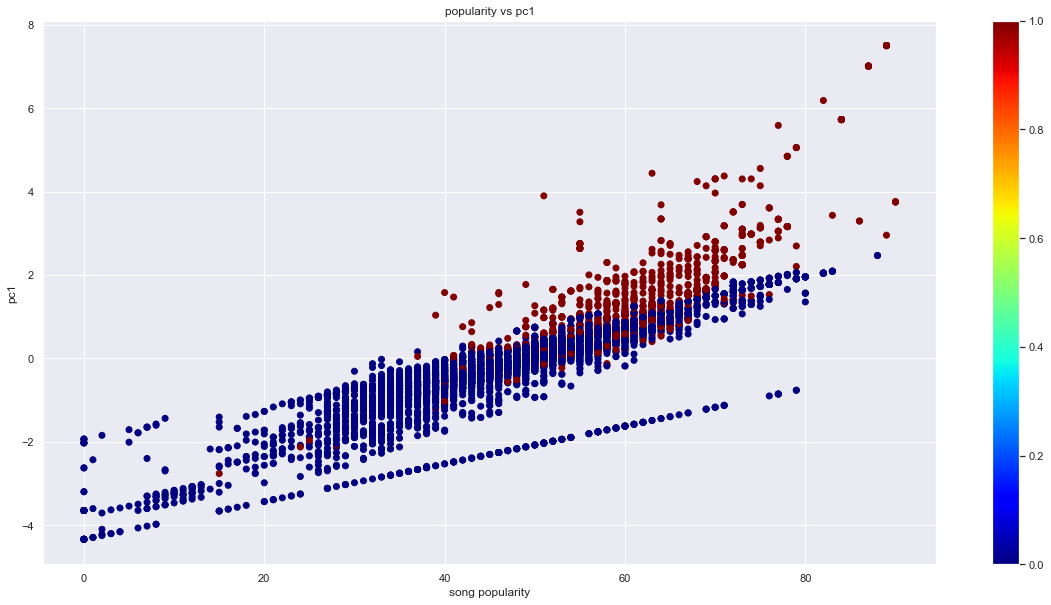

In [22]:
fig, ax = plt.subplots(figsize = (20, 10))
points = plt.scatter(df_pca_trf['song_popularity'] , df_pca_trf['pc1'], c = df_pca_trf['bb_appear'], cmap = 'jet')
plt.colorbar(points)
ax.set(title = 'popularity vs pc1', xlabel = 'song popularity', ylabel = 'pc1')
plt.show()

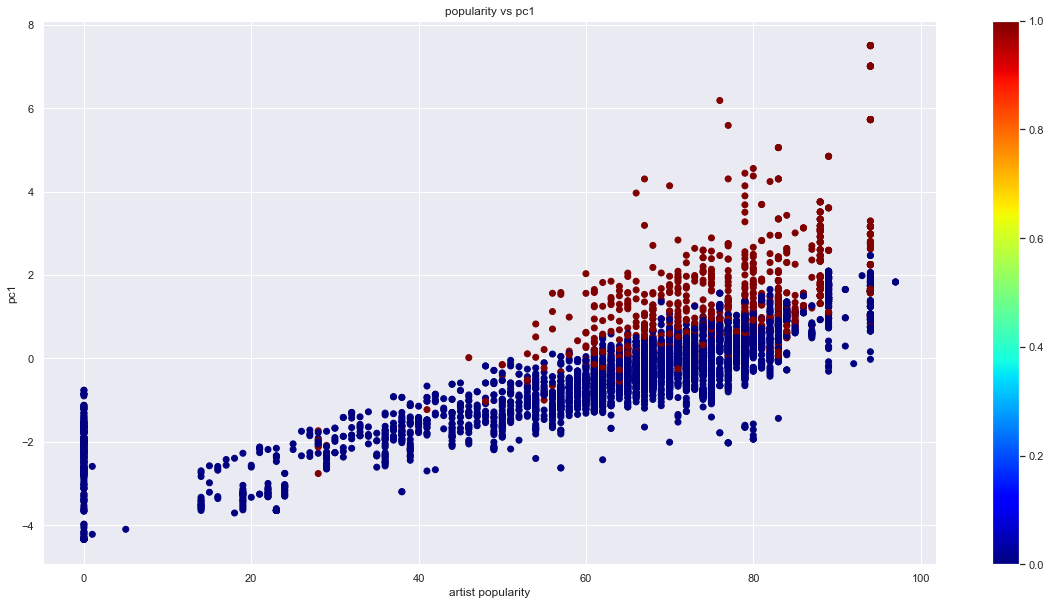

In [23]:
fig, ax = plt.subplots(figsize = (20, 10))
points = plt.scatter(df_pca_trf['artist_popularity'] , df_pca_trf['pc1'], c = df_pca_trf['bb_appear'], cmap = 'jet')
plt.colorbar(points)
ax.set(title = 'popularity vs pc1', xlabel = 'artist popularity', ylabel = 'pc1')
plt.show()

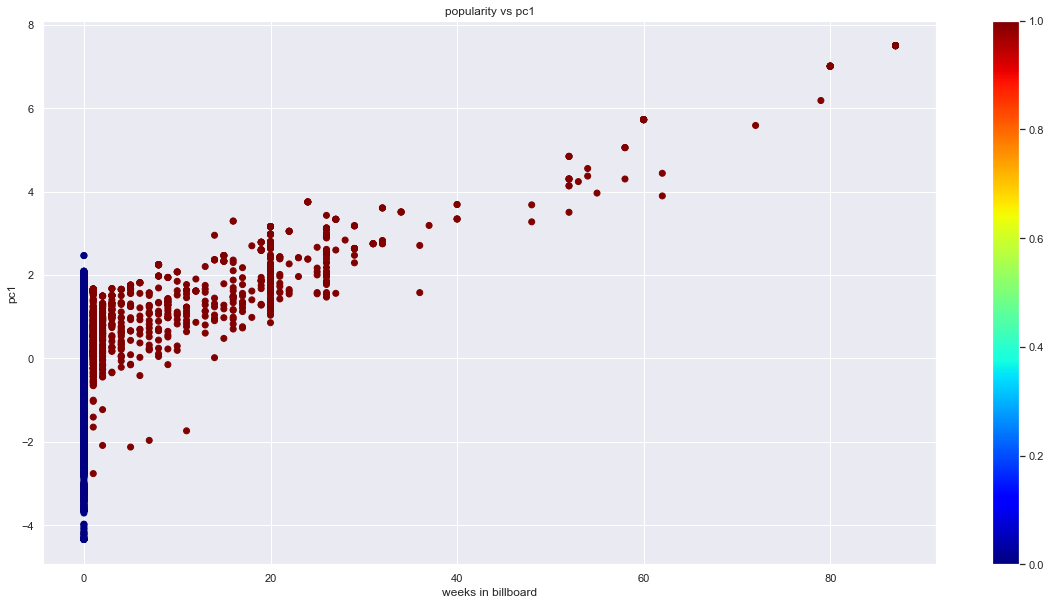

In [24]:
fig, ax = plt.subplots(figsize = (20, 10))
points = plt.scatter(df_pca_trf['n_weeks'] , df_pca_trf['pc1'], c = df_pca_trf['bb_appear'], cmap = 'jet')
plt.colorbar(points)
ax.set(title = 'popularity vs pc1', xlabel = 'weeks in billboard', ylabel = 'pc1')
plt.show()

In [26]:
df['pc1_popularity_index'] = df_pca_trf['pc1']

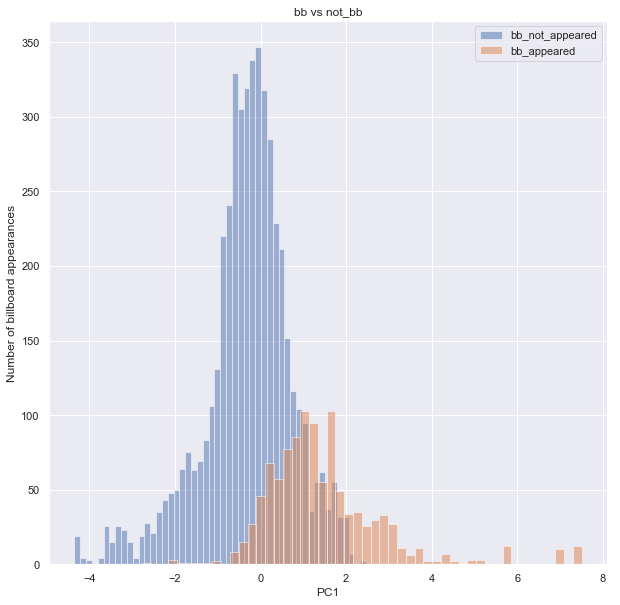

In [28]:
from matplotlib import pyplot

x0 = df_t[df_t['bb_appear'] == 0]['pc1_popularity_index']
x1 = df_t[df_t['bb_appear'] == 1]['pc1_popularity_index']

fig, ax = plt.subplots(figsize = (10, 10))
plt.hist(x0, bins = 50, alpha=0.5, label='bb_not_appeared')
plt.hist(x1, bins = 50, alpha=0.5, label='bb_appeared')
plt.legend(loc='upper right')
plt.xlabel('PC1')
plt.ylabel('Number of billboard appearances')
plt.title('bb vs not_bb')
plt.show()

### It is apparent from the above visualizations that the index separates the two classes reasonably well. Now we proceed to regression analysis

# Regression

In [21]:
#Scaling the pc1_1 target variable

In [22]:
sc = MinMaxScaler(feature_range=(0, 1), copy = True)

In [31]:
# normalizing the created index
df['pc1_1_norm'] = (df['pc1_popularity_index'] - df['pc1_popularity_index'].min())/(df['pc1_popularity_index'].max() - df['pc1_popularity_index'].min())

In [30]:
# Using a KNeighbors Regressor
def get_pred_KNNR(X_train_res, y_train_res, X_test, y_test):
    
    X_train_res = X_train_res.drop('bb_appear', axis = 1)
    bb_appear = X_test['bb_appear']
    X_test = X_test.drop('bb_appear', axis = 1)
    
    # hyperparameters
    params = {"n_neighbors": np.arange(1, 21, 2),
              "metric": ["euclidean", "cityblock"],
              "algorithm": ["ball_tree", "kd_tree", "brute"]}
    
    nbrs = KNeighborsRegressor()
    grid = GridSearchCV(estimator = nbrs, param_grid = params, cv = 5, refit = True, scoring = 'accuracy')
    best_model = grid.fit(X_train_res, y_train_res)
    y_pred = best_model.predict(X_test)
    results = pd.DataFrame(data = {'predictions': y_pred, 'true_output': y_test, 'bb_appear': bb_appear})
    
    return [results, best_model.best_score_, best_model.best_params_]

In [25]:
# Using a Ridge Regressor
def get_pred_Ridge(X_train_res, y_train_res, X_test, y_test):
    X_train_res = X_train_res.drop('bb_appear', axis = 1)
    bb_appear = X_test['bb_appear']
    X_test = X_test.drop('bb_appear', axis = 1)
    
    param_grid = {
                    'fit_intercept': [True, False],
                    'alpha': [1,0.1 ,0.01, 0.001],
                    'normalize': [True, False],
                    'solver': ['svd', 'cholesky', 'lsqr']
                }
    
    model = Ridge()
    gcv_ridge = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, refit = True)
    best_model = gcv_ridge.fit(X_train_res, y_train_res)
    y_pred = best_model.predict(X_test)
    results = pd.DataFrame(data = {'predictions': y_pred, 'true_output': y_test, 'bb_appear': bb_appear})
    
    return [results, best_model.best_score_, best_model.best_params_]    

In [26]:
# Using a Support Vector Regressor
def get_pred_SVR(X_train_res, y_train_res, X_test, y_test):
    X_train_res = X_train_res.drop('bb_appear', axis = 1)
    bb_appear = X_test['bb_appear']
    X_test = X_test.drop('bb_appear', axis = 1)
    
    param_grid = {
                    'kernel': ['linear', 'rbf'],
                    'C':[0.1, 1, 10],
                    'gamma':[0.0001, 0.001, 0.01, 0.1]
                }
    
    svr_model = SVR()
    gcv_svr = GridSearchCV(estimator = svr_model, param_grid = param_grid, cv = 5, refit = True)
    best_model = gcv_svr.fit(X_train_res, y_train_res)
    y_pred = best_model.predict(X_test)
    results = pd.DataFrame(data = {'predictions': y_pred, 'true_output': y_test, 'bb_appear': bb_appear})
    
    return [results, best_model.best_score_, best_model.best_params_]    

In [27]:
# Default Model
def get_pred_default(X_train_res, y_train_res, X_test, y_test):
    bb_appear = X_test['bb_appear']
    y_pred = np.ones(n) * np.mean(y_train)
    results = pd.DataFrame(data = {'predictions': y_pred, 'true_output': y_test, 'bb_appear': bb_appear})
    
    return [results, 'default', 'default']    

In [28]:
# function to get classification metrics
def get_metrics(pred_df, cutoff = 0.5):
    # replacing the probabilities with the target labels
    pred_df['predictions_int'] = np.where(pred_df.predictions.values >= cutoff, 1, 0)
    #pred_df['bb_appear'] = np.where(pred_df.bb_appear.values == 2, 1, 0)
    pred_df = pred_df.astype(int)

    # getting the confusion matrix    
    cf_mat = confusion_matrix(pred_df.bb_appear, pred_df.predictions_int)
    
    fig, ax = plt.subplots(figsize=(3,3))

    sns.heatmap(cf_mat, annot = True, fmt = 'd', xticklabels = [0, 1], yticklabels = [0, 1])

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
        
    # getting the False Positives, False Negatives, True Positives and True Negatives
    FP = cf_mat.sum(axis = 0) - np.diag(cf_mat)  
    FN = cf_mat.sum(axis = 1) - np.diag(cf_mat)
    TP = np.diag(cf_mat)
    TN = cf_mat.sum() - (FP + FN + TP)
    
    df_metrics = pd.DataFrame()
    
    # storing the true positive rate, false positive rate, accuracy and precision in a dataframe
    df_metrics['tpr'] = TP / (TP + FN)
    df_metrics['fpr'] = FP / (FP + TN)
    df_metrics['accuracy'] = (TP + TN) / (TP + FP + FN + TN)
    df_metrics['precision'] = TP / (TP + FP)
    df_metrics['recall'] = TP / (TP + FN)
    df_metrics['F score'] = 2 * (df_metrics['precision'] * df_metrics['recall'])/(df_metrics['precision'] + df_metrics['recall'])
    
    print(df_metrics.loc[1])

In [41]:
# function to plot ROC curve
def plot_roc(pred_df, cutoff = 0.5):

    fpr, tpr, thresholds = roc_curve(pred_df['bb_appear'].astype('int'), pred_df['predictions'], pos_label = 1)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize = (20, 10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.5f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [38]:
# function to scale and binarize features
def scale_and_binarize(df):
    cat_cols = df.select_dtypes(include = 'object').drop('bb_appear', axis = 1)
    cat_cols = pd.get_dummies(cat_cols, drop_first = True)
    
    num_cols = df.select_dtypes(exclude = 'object')
    num_cols = pd.DataFrame(StandardScaler().fit_transform(num_cols), columns = num_cols.columns)
    
    df_t = pd.concat([num_cols, cat_cols, df.bb_appear], axis = 1)
    
    return df_t

In [33]:
def conv_to_obj(a):
    return str(int(a))

def prepare_data():
    df['mode'] = df['mode'].apply(conv_to_obj)
    df['time_signature'] = df['time_signature'].apply(conv_to_obj)
    df['explicit'] = df['explicit'].apply(conv_to_obj)
    df['key'] = df['key'].apply(conv_to_obj)
    df['bb_appear'] = df['bb_appear'].apply(conv_to_obj)
    
    X = scale_and_binarize(df.drop(['Unnamed: 0', 'weeks', 'album_popularity', 'track_popularity',
                                    'artist_followers', 'artist_popularity', 'pc1_popularity_index'], axis = 1))
    
    y = df['pc1_popularity_index']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    return X_train, y_train, X_test, y_test

In [34]:
# shuffle the input dataset
df = df.sample(frac = 1).reset_index(drop = True)

# get the source and target
X_train, y_train, X_test, y_test = prepare_data()

model_predictions = {
    'knn_pred': get_pred_KNNR(X_train, y_train, X_test, y_test),
    'ridge_pred': get_pred_Ridge(X_train, y_train, X_test, y_test),
    'svr_pred': get_pred_SVR(X_train, y_train, X_test, y_test)
}


/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


---------------Model:  ridge_pred --------------

CV Results on the training data data:
GCV best score:  0.9999999999999282 
GCV best parameters:  {'alpha': 0.001, 'fit_intercept': True, 'normalize': False, 'solver': 'svd'} 

Results on the hold-out test data:

rmse:  2.7249174591396e-07
r2:  0.999999999999955
Evaluating with different thresholds

threshold:  0.4 

Accuracy Metrics: 



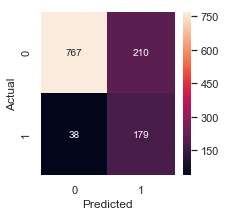

tpr          0.824885
fpr          0.214944
accuracy     0.792295
precision    0.460154
recall       0.824885
F score      0.590759
Name: 1, dtype: float64


Evaluating with different thresholds

threshold:  0.5 

Accuracy Metrics: 



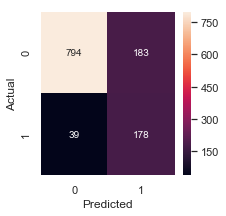

tpr          0.820276
fpr          0.187308
accuracy     0.814070
precision    0.493075
recall       0.820276
F score      0.615917
Name: 1, dtype: float64


Evaluating with different thresholds

threshold:  0.6 

Accuracy Metrics: 



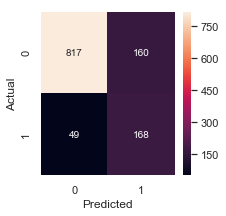

tpr          0.774194
fpr          0.163767
accuracy     0.824958
precision    0.512195
recall       0.774194
F score      0.616514
Name: 1, dtype: float64




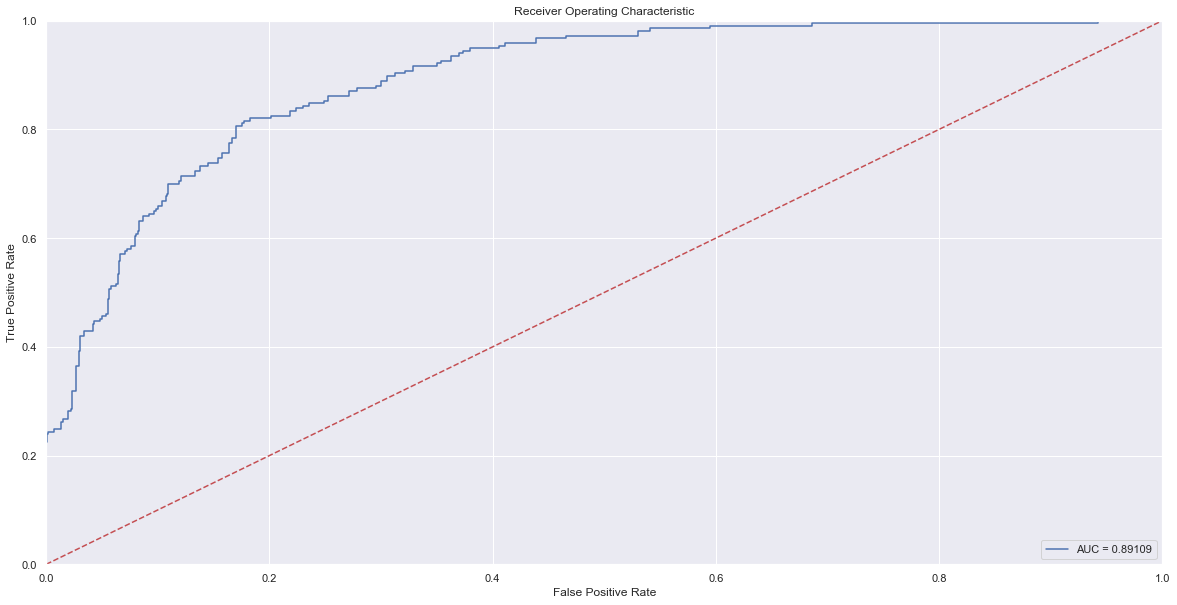

---------------Model:  svr_pred --------------

CV Results on the training data data:
GCV best score:  0.999334670314188 
GCV best parameters:  {'C': 0.1, 'gamma': 0.0001, 'kernel': 'linear'} 

Results on the hold-out test data:

rmse:  0.03293654590440538
r2:  0.9993429832512404
Evaluating with different thresholds

threshold:  0.4 

Accuracy Metrics: 



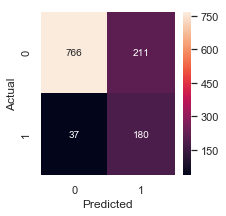

tpr          0.829493
fpr          0.215967
accuracy     0.792295
precision    0.460358
recall       0.829493
F score      0.592105
Name: 1, dtype: float64


Evaluating with different thresholds

threshold:  0.5 

Accuracy Metrics: 



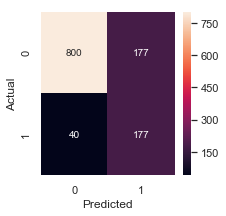

tpr          0.815668
fpr          0.181167
accuracy     0.818258
precision    0.500000
recall       0.815668
F score      0.619965
Name: 1, dtype: float64


Evaluating with different thresholds

threshold:  0.6 

Accuracy Metrics: 



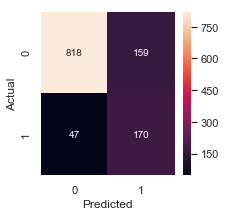

tpr          0.783410
fpr          0.162743
accuracy     0.827471
precision    0.516717
recall       0.783410
F score      0.622711
Name: 1, dtype: float64




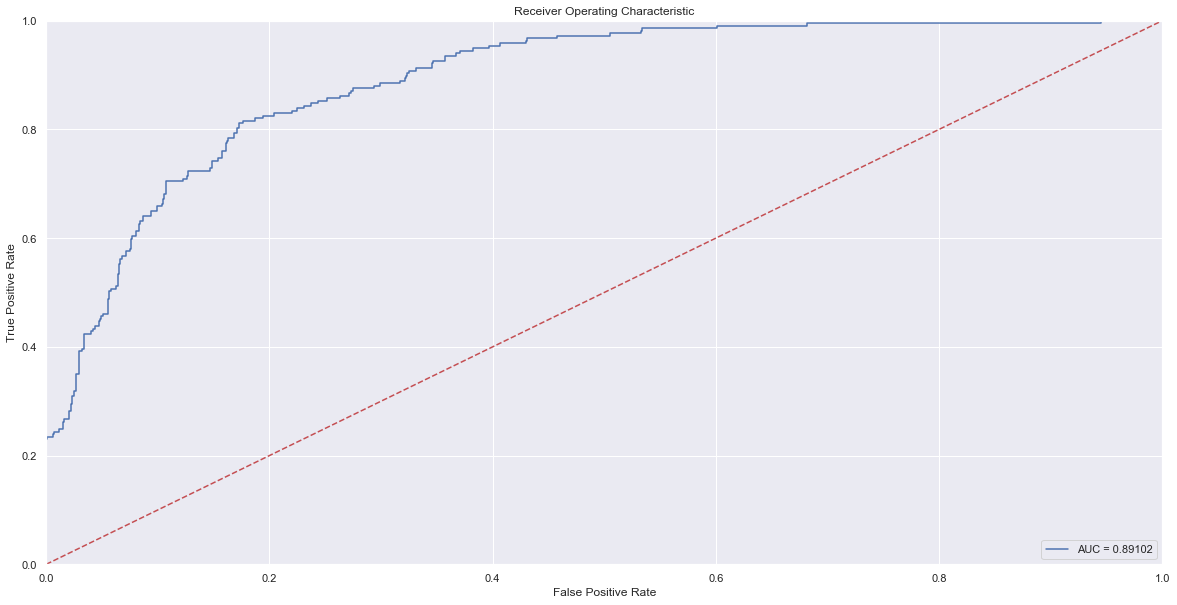

In [48]:
'''
    if our model predicts that the current song has a normalized popularity index of more than 0.8,
    then label it as positive, otherwise negative. This is how we have evaluated our regression model
    using classification metrics.
'''

    for key, value in model_predictions.items():
        print('---------------Model: ', key, "--------------\n")
        print('CV Results on the training data data:')
        print('GCV best score: ', value[1], "")
        print('GCV best parameters: ', value[2], "\n")
        print('Results on the hold-out test data:\n')
        print('rmse: ', np.sqrt(np.square(value[0]['predictions'] - value[0]['true_output']).mean()))
        print('r2: ', r2_score(value[0]['true_output'], value[0]['predictions']))
        for i in [0.4, 0.5, 0.6]:
        #for i in [0.4]:
            print("Evaluating with different thresholds\n")
            print('threshold: ', i, "\n")
            print('Accuracy Metrics: \n')
            get_metrics(value[0], i)
            print("\n")
        plot_roc(value[0], i)